<br>

# Mapping with ggplot

This document outlines a number of extension areas related to plotting spatial data in ggplot.

### Imports

In [1]:
library(sf)
library(ggplot2)
library(zeallot)

source('../scripts/helpers.R') 

Warning message:
"package 'sf' was built under R version 3.6.3"
Linking to GEOS 3.8.0, GDAL 3.0.4, PROJ 6.3.1

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

Warning message:
"package 'zeallot' was built under R version 3.6.3"


<br>

### Loading Example Data



In [2]:
df_country <- read_sf('../data/zambia/zambia.shp')
df_africa_cities <- read_sf('../data/africa/cities.shp')

<br>

### Identifying Spatial Plotting Limits

Earlier in this tutorial we had to specify axis limits in order to reduce the area of Africa plotted. In that example we hardcoded the values, but how did we arrive at those values? and how could we automate this process in the future?

First we'll create a function that takes a spatial dataframe and returns the min and max values from the x and y coordinates.

In [3]:
get_geo_df_limits <- function(df){
    # Extracting x/y coordinates
    df_coords <- st_coordinates(df)
    
    # Separating x/y coordinates
    x_vals <- df_coords[, 1]
    y_vals <- df_coords[, 2]

    # Identifying the limits of x/y
    min_x <- min(x_vals)
    max_x <- max(x_vals)
    min_y <- min(y_vals)
    max_y <- max(y_vals)
    
    limits <- c(min_x, max_x, min_y, max_y)
    
    return(limits)
}

geo_df_limits <- get_geo_df_limits(df_country)

geo_df_limits

[1]  -42815.6 1235177.2 8001294.5 9089236.3

<br>

But what should we do when we want to use the limits from one dataframe, whilst plotting it alongside another dataframe that's in a different coordinate system?

We'll start by extracting the limits again.

In [4]:
geo_df_limits <- get_geo_df_limits(df_africa_cities)

geo_df_limits

[1] -25.10000  63.47000 -34.53333  37.27444

<br>

Then we can write another function that will convert these limit coordinates from one crs into another.

N.b. normally a bounding box (bbox) refers to a Polygon or Linestring where the vertices are the corners of the bbox. In this example we refer to bbox corners as only the top right and bottom left corners, this is because for a rectangular bbox they can be used to define the full shape.

In [5]:
transform_bbox_corner_crs <- function(min_x_in, max_x_in, 
                                      min_y_in, max_y_in, 
                                      crs_in, crs_out) {
    
    bottom_left <- st_point(c(min_x_in, min_y_in))
    top_right <- st_point(c(max_x_in, max_y_in))

    bbox_corners_in <- st_sfc(bottom_left, top_right, crs=crs_in)
    bbox_corners_out <- st_transform(bbox_corners_in, crs=crs_out)
    
    df_bbox_out <- st_coordinates(bbox_corners_out)

    min_x_out <- df_bbox_out[1, 1]
    max_x_out <- df_bbox_out[2, 1]
    min_y_out <- df_bbox_out[1, 2]
    max_y_out <- df_bbox_out[2, 2]
    
    return(c(min_x_out, max_x_out, min_y_out, max_y_out))
}

c(min_x_in, max_x_in, min_y_in, max_y_in) %<-% geo_df_limits

crs_in <- 4326
crs_out <- 20935
    
out_coords <- transform_bbox_corner_crs(min_x_in, max_x_in, 
                                        min_y_in, max_y_in, 
                                        crs_in, crs_out)

out_coords

[1] -4449293  3780759  4648881 14811142

<br>

We can now use these coordinates to define the ggplot plotting limits

In [6]:
c(min_x_out, max_x_out, min_y_out, max_y_out) %<-% out_coords

coord_lims <- coord_sf(xlim=c(min_x_out, max_x_out), 
                       ylim=c(min_y_out, max_y_out))

coord_lims

<ggproto object: Class CoordSf, CoordCartesian, Coord, gg>
    aspect: function
    backtransform_range: function
    clip: on
    crs: NULL
    datum: crs
    default: FALSE
    distance: function
    expand: TRUE
    fixup_graticule_labels: function
    is_free: function
    is_linear: function
    label_axes: list
    label_graticule: 
    labels: function
    limits: list
    modify_scales: function
    ndiscr: 100
    range: function
    render_axis_h: function
    render_axis_v: function
    render_bg: function
    render_fg: function
    setup_data: function
    setup_layout: function
    setup_panel_params: function
    setup_params: function
    transform: function
    super:  <ggproto object: Class CoordSf, CoordCartesian, Coord, gg>

<br>

Putting this all together we'll write a single function that accepts a dataframe, extracts its x/y limits, optionally converts them into a new CRS, then finally generates ggplot coordinate limits from them.

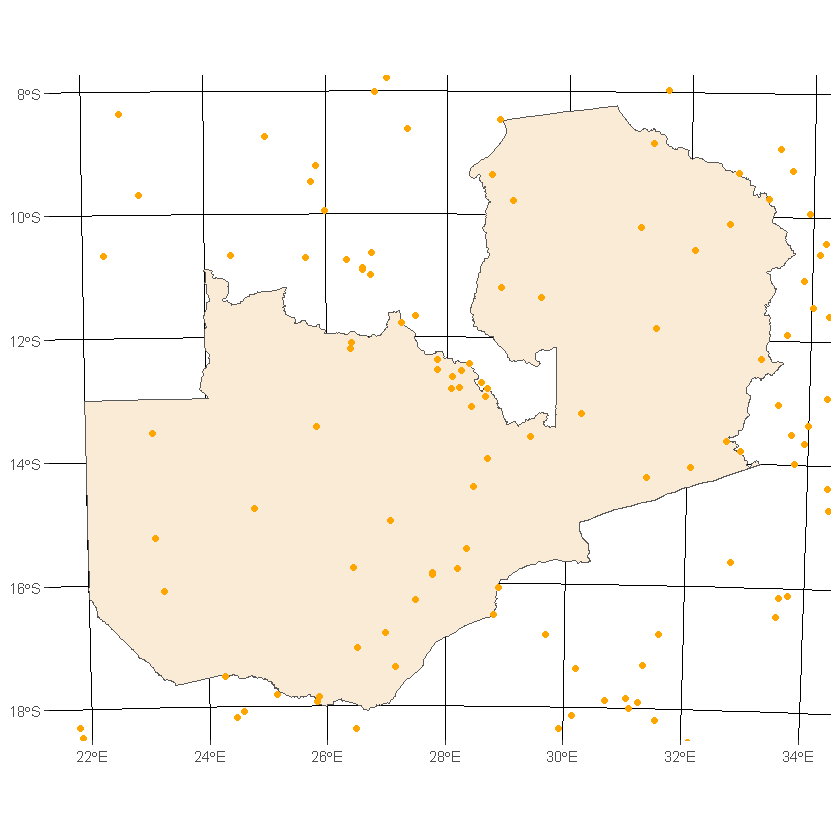

In [7]:
get_geo_df_plot_lims <- function(df, crs_out=NA){
    # Identify limits
    geo_df_limits <- get_geo_df_limits(df)
    c(min_x_out, max_x_out, min_y_out, max_y_out) %<-% geo_df_limits

    # Optionally convert to new crs
    if (!is.na(crs_out)) {
        crs_in <- extract_epsg_from_df(df) %>%
                    strtoi() %>%
                    st_crs

        out_coords <- transform_bbox_corner_crs(min_x_in, max_x_in, 
                                                min_y_in, max_y_in, 
                                                crs_in, crs_out)

        c(min_x_out, max_x_out, min_y_out, max_y_out) %<-% out_coords
    }

    # Convert to ggplot2 coordinate limits
    coord_lims <- coord_sf(xlim=c(min_x_out, max_x_out), 
                           ylim=c(min_y_out, max_y_out))
    
    return(coord_lims)
}

coord_lims <- get_geo_df_plot_lims(df_country)

transparent_theme <- theme(
    panel.grid.major = element_blank(), 
    panel.grid.minor = element_blank(),
    panel.background = element_rect(fill='transparent', colour=NA),
    plot.background = element_rect(fill='transparent', colour=NA)
)

ggplot() +
    geom_sf(data=df_country, fill='antiquewhite') +
    geom_sf(data=df_africa_cities, color='orange') + 
    coord_lims + 
    transparent_theme

<br>

We can now very quickly switch between different plotting views

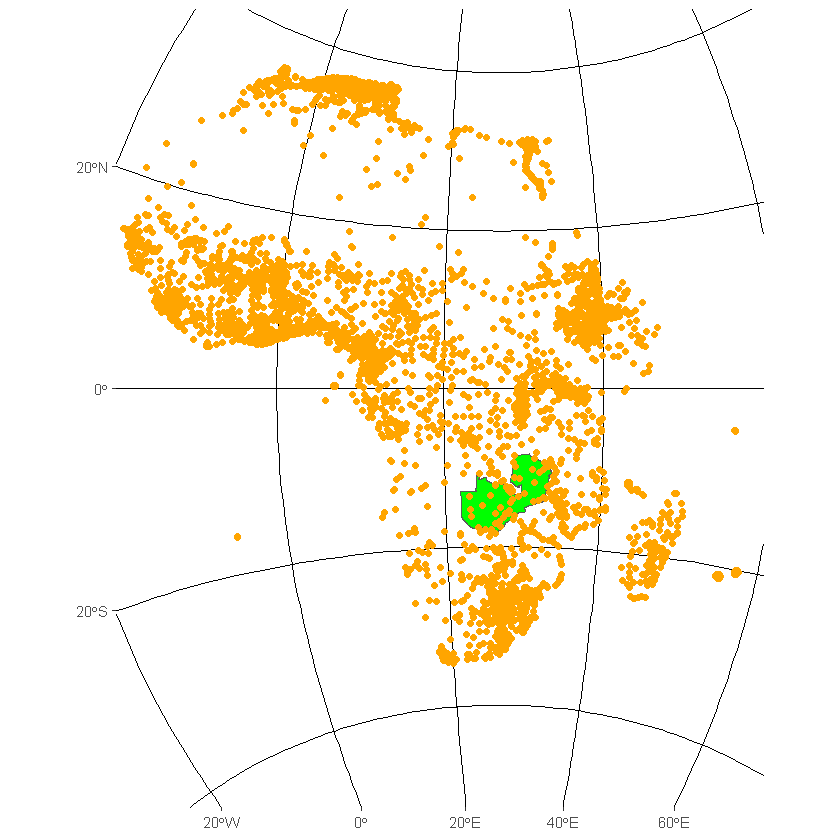

In [8]:
coord_lims <- get_geo_df_plot_lims(df_africa_cities, crs_out=20935)

ggplot() +
    geom_sf(data=df_country, fill='green') +
    geom_sf(data=df_africa_cities, color='orange') + 
    coord_lims + 
    transparent_theme